In [1]:
# module imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

# model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix



Data extraction****
here we upload our dataset

In [2]:
# fetch the training file
file_path_20_percent = '/content/KDDTrain+_20Percent.txt'
file_path_full_training_set = '/content/KDDTrain+.txt'
file_path_test = '/content/KDDTest+.txt' 

#df = pd.read_csv(file_path_20_percent)
df = pd.read_csv(file_path_full_training_set)
test_df = pd.read_csv(file_path_test)

In [3]:
#data set doesn't include column names, add them.
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df.columns = columns
test_df.columns = columns

# sanity check
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15.0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19.0
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21.0
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21.0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21.0


**Data transformations**
I adding a column that encodes 'normal' values as 0 and any other value as 1. We will use this as our classifier for a simple binary model that idenfities any attack.

In [4]:
# map normal to 0, all attacks to 1
is_attack = df.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_df.attack.map(lambda a: 0 if a == 'normal' else 1)

#data_with_attack = df.join(is_attack, rsuffix='_flag')
df['attack_flag'] = is_attack
test_df['attack_flag'] = test_attack

# view the result
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag
0,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15.0,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19.0,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21.0,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21.0,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21.0,1


I classify each of the attacks according to attack type for a more granular prediction model.

In [5]:
# lists to hold our attack classifications
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
U2R = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
Sybil = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

# we will use these for plotting below
attack_labels = ['Normal','DoS','Probe','U2R','Sybil']

# helper function to pass to data frame mapping
def map_attack(attack):
    if attack in dos_attacks:
        # dos_attacks map to 1
        attack_type = 1
    elif attack in probe_attacks:
        # probe_attacks mapt to 2
        attack_type = 2
    elif attack in U2R:
        # privilege escalation attacks map to 3
        attack_type = 3
    elif attack in Sybil:
        # remote access attacks map to 4
        attack_type = 4
    else:
        # normal maps to 0
        attack_type = 0
        
    return attack_type

# map the data and join to the data set
attack_map = df.attack.apply(map_attack)
df['attack_map'] = attack_map

test_attack_map = test_df.attack.apply(map_attack)
test_df['attack_map'] = test_attack_map

# view the result
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,attack_map
0,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.0,0.00,normal,15.0,0,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19.0,1,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.0,0.01,normal,21.0,0,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.0,0.00,normal,21.0,0,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21.0,1,1


**Data profiling**
i put in table of attack by protocol. 

In [6]:
# attack vs MCS protocols
attack_vs_protocol = pd.crosstab(df.attack, df.protocol_type)
attack_vs_protocol

protocol_type,icmp,tcp,udp
attack,,,
back,0,439,0
buffer_overflow,0,16,0
ftp_write,0,3,0
guess_passwd,0,22,0
imap,0,5,0
ipsweep,1361,211,0
land,0,4,0
loadmodule,0,3,0
multihop,0,5,0


**Visual Representation of Dataset**
 see how things are distributed.

In [7]:
# helper function for drawing mulitple charts.
def bake_pies(data_list,labels):
    list_length = len(data_list)
    
    # setup for mapping colors
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}
    
    # build the subplots
    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)
    
    # loop through the data sets and build the charts
    for count, data_set in enumerate(data_list): 
        
        # update our color mapt with new values
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)
       
        # build the wedges
        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])

        # build the legend
        axs[count].legend(wedges, data_set.index,
                           title="Flags",
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
        # set the title
        axs[count].set_title(labels[count])
        
    return axs   



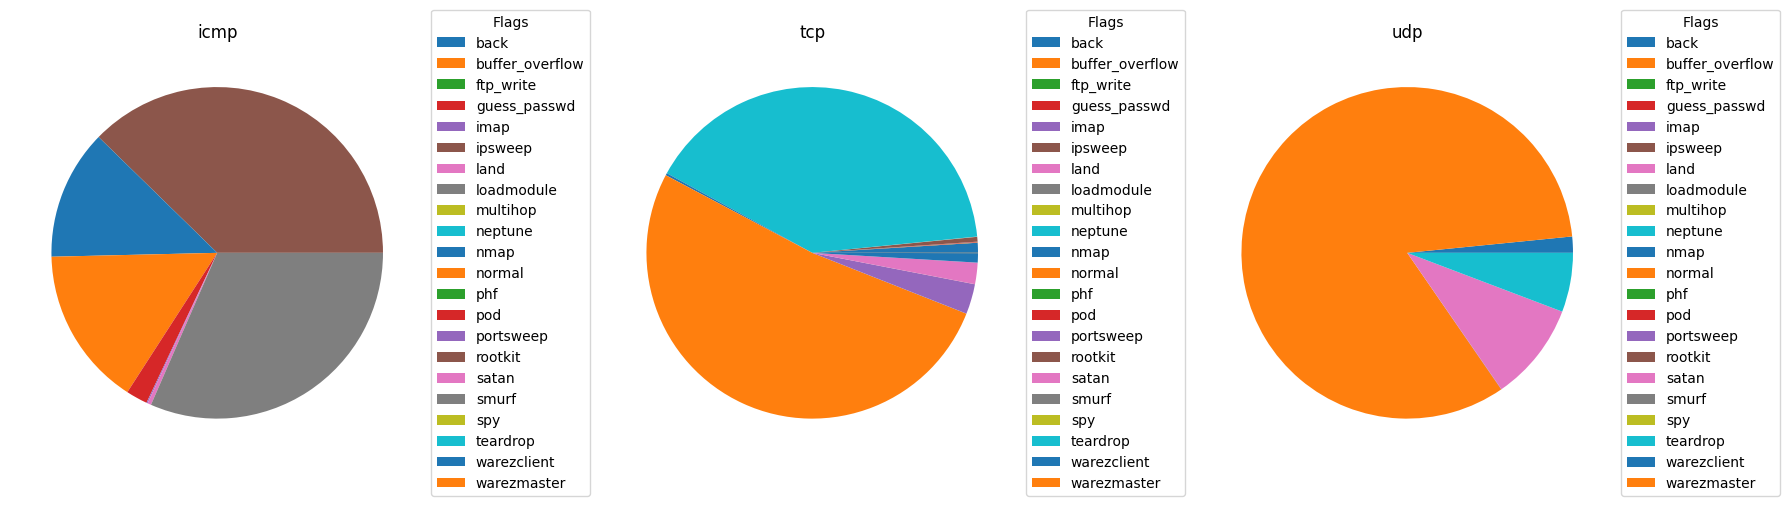

In [8]:
# get the series for each protocol
icmp_attacks = attack_vs_protocol.icmp
tcp_attacks = attack_vs_protocol.tcp
udp_attacks = attack_vs_protocol.udp

# create the charts
bake_pies([icmp_attacks, tcp_attacks, udp_attacks],['icmp','tcp','udp'])
plt.show()

Our monitoring strategy uses a series continuous network protocols and capable of learning subtle distinction between threats and legal ones. Historical information fed the machine learning model classify Sybil and other attacks (ddos, probe, u2r). It helps to identify recurring patterns of Sybil, DDoS, U2R, Probe attacks and locate in long-term traffic chain.

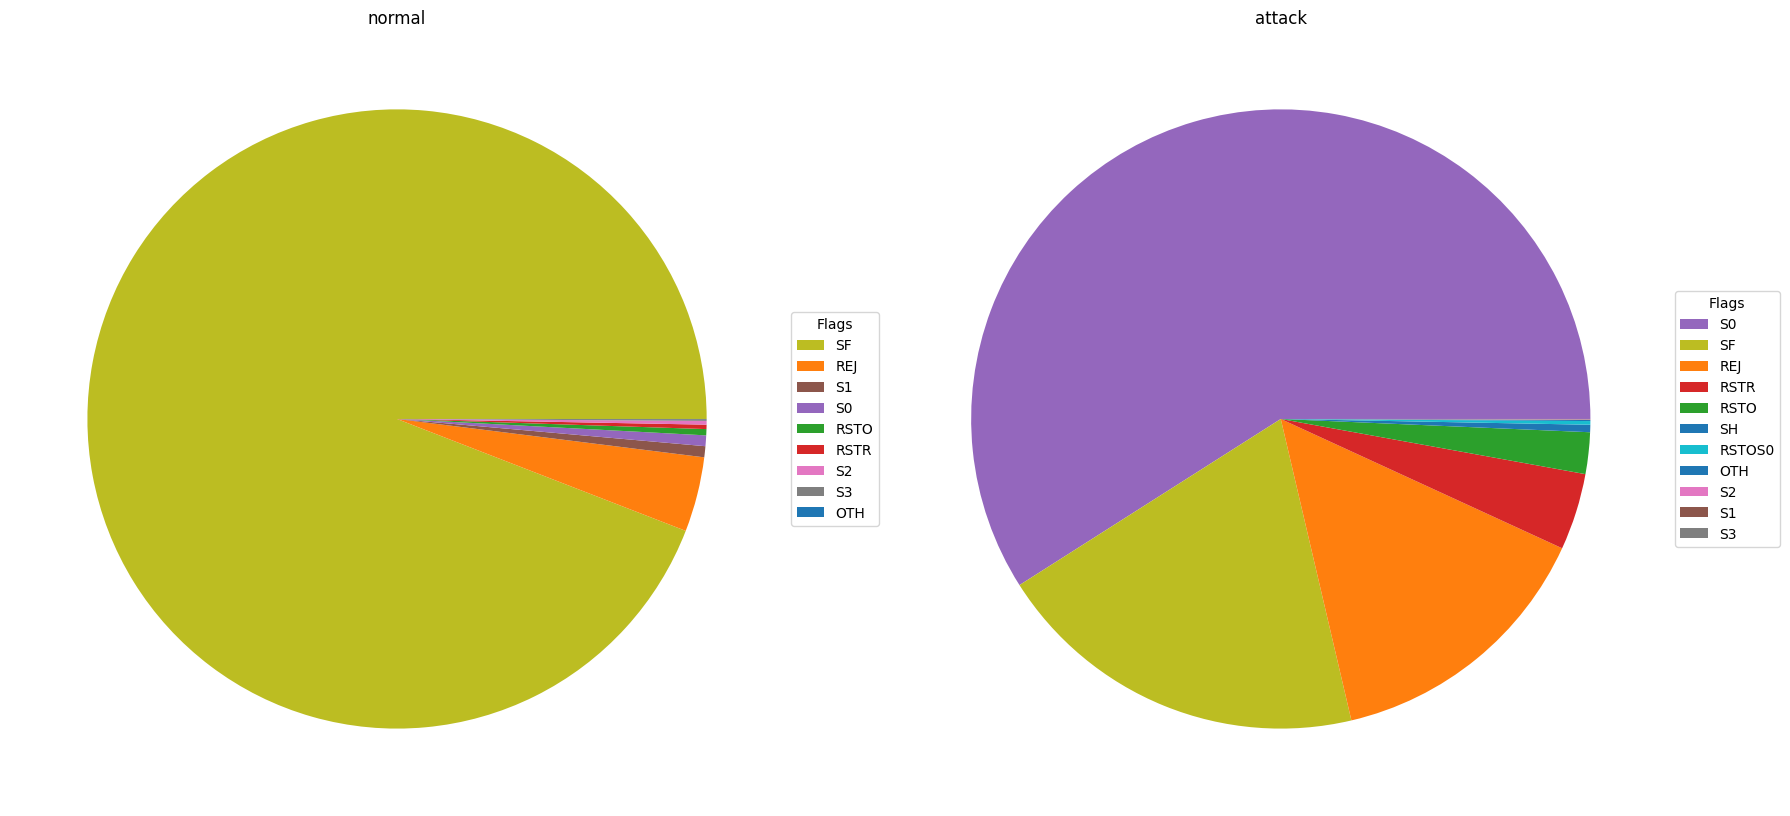

In [9]:
# get a series with the count of each flag for attack and normal traffic
normal_flags = df.loc[df.attack_flag == 0].flag.value_counts()
attack_flags = df.loc[df.attack_flag == 1].flag.value_counts()

# create the charts
flag_axs = bake_pies([normal_flags, attack_flags], ['normal','attack'])        
plt.show()

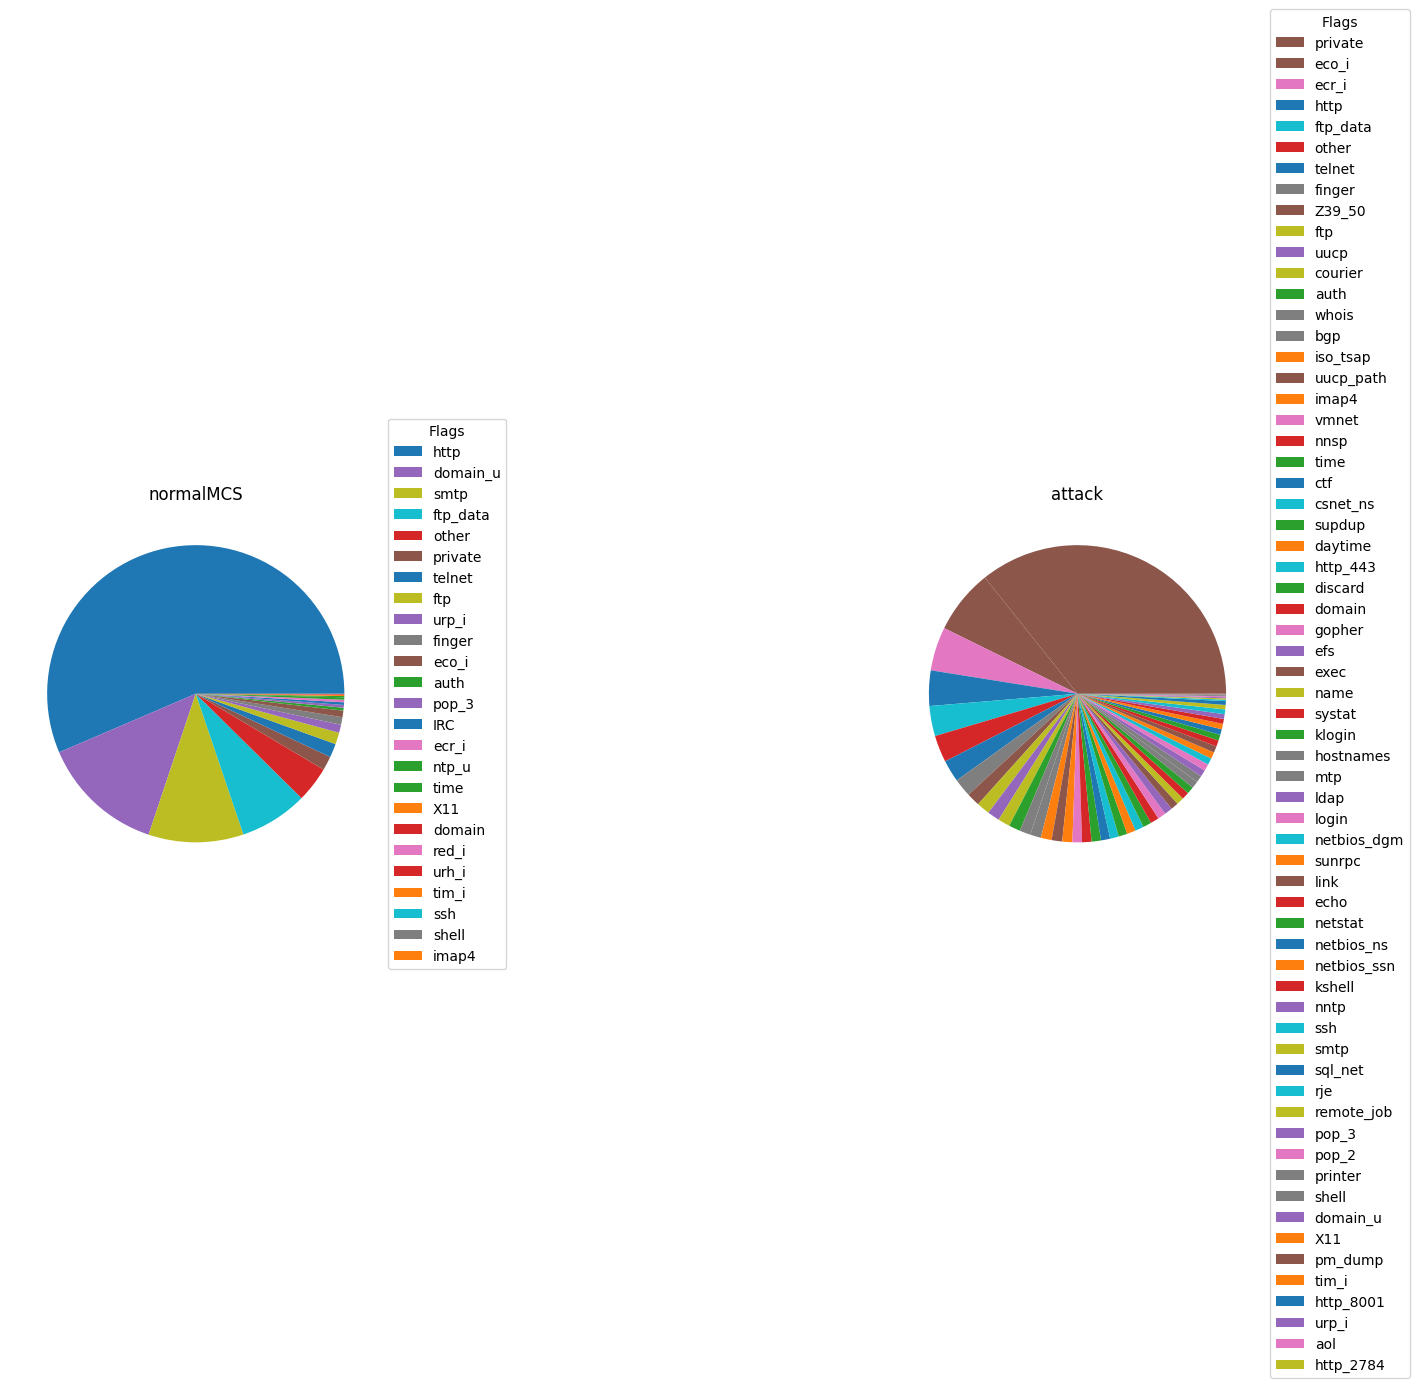

In [10]:
# get a series with the count of each service for attack and normal MCS
normal_services = df.loc[df.attack_flag == 0].service.value_counts()
attack_services = df.loc[df.attack_flag == 1].service.value_counts()

# create the charts
service_axs = bake_pies([normal_services, attack_services], ['normalMCS','attack'])        
plt.show()


Our data show that huge normal traffic is http, our attack traffic is all over the MCS. Sybil ttacks are searching for many different paths into MCS systems; some well traveled and some not.



**Feature engineering**


In [11]:
# get the intial set of encoded features and encode them
features_to_encode = ['protocol_type', 'service', 'flag']
encoded = pd.get_dummies(df[features_to_encode])
test_encoded_base = pd.get_dummies(test_df[features_to_encode])

# not all of the features are in the test set, so we need to account for diffs
test_index = np.arange(len(test_df.index))
column_diffs = list(set(encoded.columns.values)-set(test_encoded_base.columns.values))

diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)

# we'll also need to reorder the columns to match, so let's get those
column_order = encoded.columns.to_list()

# append the new columns
test_encoded_temp = test_encoded_base.join(diff_df)

# reorder the columns
test_final = test_encoded_temp[column_order].fillna(0)

# get numeric features, we won't worry about encoding these at this point
numeric_features = ['duration', 'src_bytes', 'dst_bytes']

# model to fit/test
to_fit = encoded.join(df[numeric_features])
test_set = test_final.join(test_df[numeric_features])

I divide the data into testing and training sets to start: binrary and multi classifications.

In [12]:
# create our target classifications
binary_y = df['attack_flag']
multi_y = df['attack_map']

test_binary_y = test_df['attack_flag']
test_multi_y = test_df['attack_map']

# build the training sets
binary_train_X, binary_val_X, binary_train_y, binary_val_y = train_test_split(to_fit, binary_y, test_size=0.6)
multi_train_X, multi_val_X, multi_train_y, multi_val_y = train_test_split(to_fit, multi_y, test_size = 0.6)

**Model fitting**
Based on the nature of the data, decision trees are a good starting point for building out predictive models. In this case we'll use a random forest to build and combine multiple trees. 

## **Accuracy of different models**

In [18]:
# model for the binary classification
binary_model = LogisticRegression()
binary_model.fit(binary_train_X, binary_train_y)
binary_predictions = binary_model.predict(binary_val_X)

# calculate and display our base accuracty
base_rf_score = accuracy_score(binary_predictions,binary_val_y)
base_rf_score

0.8193326702233475

In [19]:
# model for the binary classification
binary_model = RandomForestClassifier()
binary_model.fit(binary_train_X, binary_train_y)
binary_predictions = binary_model.predict(binary_val_X)

# calculate and display our base accuracty
base_rf_score = accuracy_score(binary_predictions,binary_val_y)
base_rf_score

0.9929770624227627

In [20]:
binary_model = KNeighborsClassifier()
binary_model.fit(binary_train_X, binary_train_y)
binary_predictions = binary_model.predict(binary_val_X)

base_rf_score = accuracy_score(binary_predictions,binary_val_y)
base_rf_score

0.9886668475148446

# **Random Forrest**

In [25]:
binary_model = RandomForestClassifier()
binary_model.fit(binary_train_X, binary_train_y)
binary_predictions = binary_model.predict(binary_val_X)


base_rf_score = f1_score(binary_predictions,binary_val_y)
base_acc_score = accuracy_score(binary_predictions,binary_val_y)
base_re_score = recall_score(binary_predictions,binary_val_y)
base_mae_score = mean_absolute_error(binary_predictions,binary_val_y)

print("F1 score of RandomForestClassifier is ",base_rf_score)
print("Accuracy of RandomForestClassifier is ",base_acc_score)
print("Recall score of RandomForestClassifier is ",base_re_score)
print("Mean absolute error of RandomForestClassifier is ",base_mae_score)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

F1 score of RandomForestClassifier is  0.9926816851215478
Accuracy of RandomForestClassifier is  0.99306748651174
Recall score of RandomForestClassifier is  0.9917350117617141
Mean absolute error of RandomForestClassifier is  0.006932513488259939


## **Logistic Regression**

In [26]:
binary_model = LogisticRegression()
binary_model.fit(binary_train_X, binary_train_y)
binary_predictions = binary_model.predict(binary_val_X)


base_rf_score = f1_score(binary_predictions,binary_val_y)
base_acc_score = accuracy_score(binary_predictions,binary_val_y)
base_re_score = recall_score(binary_predictions,binary_val_y)
base_mae_score = mean_absolute_error(binary_predictions,binary_val_y)

print("F1 score of LogisticRegression is ",base_rf_score)
print("Accuracy of LogisticRegression is ",base_acc_score)
print("Recall score of LogisticRegression is ",base_re_score)
print("Mean absolute error of LogisticRegression is ",base_mae_score)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

F1 score of LogisticRegression is  0.7815438443035208
Accuracy of LogisticRegression is  0.8193326702233475
Recall score of LogisticRegression is  0.9133657040633785
Mean absolute error of LogisticRegression is  0.1806673297766525


# **K Neighbors Classifier**

In [27]:
binary_model = KNeighborsClassifier()
binary_model.fit(binary_train_X, binary_train_y)
binary_predictions = binary_model.predict(binary_val_X)


base_rf_score = f1_score(binary_predictions,binary_val_y)
base_acc_score = accuracy_score(binary_predictions,binary_val_y)
base_re_score = recall_score(binary_predictions,binary_val_y)
base_mae_score = mean_absolute_error(binary_predictions,binary_val_y)

print("F1 score of KNeighborsClassifier is ",base_rf_score)
print("Accuracy of KNeighborsClassifier is ",base_acc_score)
print("Recall score of KNeighborsClassifier is ",base_re_score)
print("Mean absolute error of KNeighborsClassifier is ",base_mae_score)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

F1 score of KNeighborsClassifier is  0.9880346232179226
Accuracy of KNeighborsClassifier is  0.9886668475148446
Recall score of KNeighborsClassifier is  0.9872178060413355
Mean absolute error of KNeighborsClassifier is  0.011333152485155379


Comapre with different model using cross_val_score.

In [14]:
# define the list of models that we want to test
models = [
    RandomForestClassifier(),
    LogisticRegression(max_iter=250),
    KNeighborsClassifier(),
]

# an empty list to capture the performance of each model
model_comps = []

# walk through the models and populate our list
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, binary_train_X, binary_train_y, scoring='accuracy')
    for count, accuracy in enumerate(accuracies):
        model_comps.append((model_name, count, accuracy))

<Axes: >

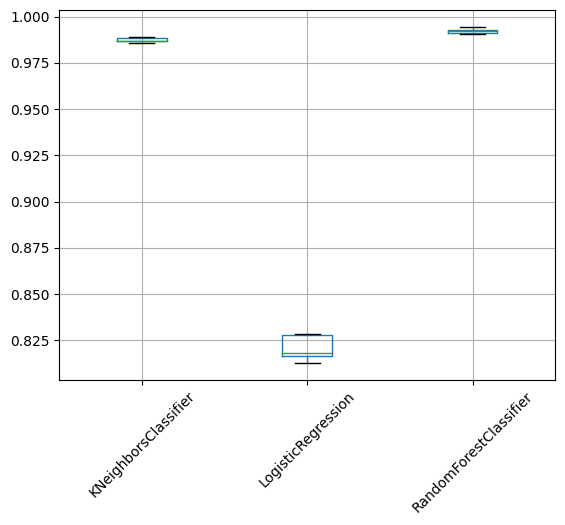

In [15]:
# a box plot will do well to show us overall performance and the variation in the models.
result_df = pd.DataFrame(model_comps, columns=['model_name', 'count', 'accuracy'])
result_df.pivot(index='count',columns='model_name',values='accuracy').boxplot(rot=45)

 random forest and K-nearest perform well but logistic give loww accuracy

**Confusion Matrix**
Now, Summarizing the performance of a classification algorithm. 

In [16]:
# a helper function for getting some analytical data about our predictions
def add_predictions(data_set,predictions,y):
    prediction_series = pd.Series(predictions, index=y.index)

    # we need to add the predicted and actual outcomes to the data
    predicted_vs_actual = data_set.assign(predicted=prediction_series)
    original_data = predicted_vs_actual.assign(actual=y).dropna()
    conf_matrix = confusion_matrix(original_data['actual'], 
                                   original_data['predicted'])
    
    # capture rows with failed predictions
    base_errors = original_data[original_data['actual'] != original_data['predicted']]
    
    # drop columns with no value
    non_zeros = base_errors.loc[:,(base_errors != 0).any(axis=0)]

    # idetify the type of error
    false_positives = non_zeros.loc[non_zeros.actual==0]
    false_negatives = non_zeros.loc[non_zeros.actual==1]

    # put everything into an object
    prediction_data = {'data': original_data,
                       'confusion_matrix': conf_matrix,
                       'errors': base_errors,
                       'non_zeros': non_zeros,
                       'false_positives': false_positives,
                       'false_negatives': false_negatives}
    
    return prediction_data


<Axes: >

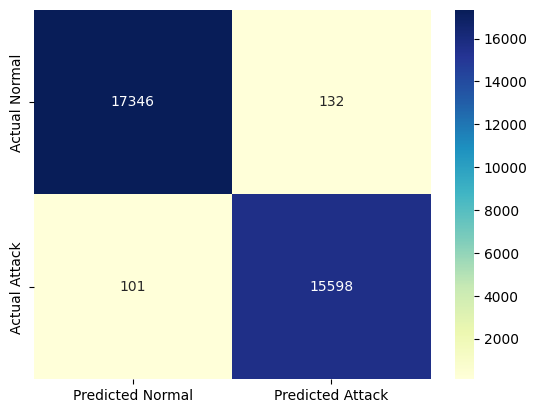

In [17]:
# capture our prediction data
binary_prediction_data = add_predictions(df,
                                         binary_predictions,
                                         binary_val_y)

# create a heatmap of the confusion matrix
sns.heatmap(data=binary_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted Normal','Predicted Attack'],
            yticklabels = ['Actual Normal','Actual Attack'],
            cmap="YlGnBu",
            fmt='d',
            annot=True)

Random Forrest


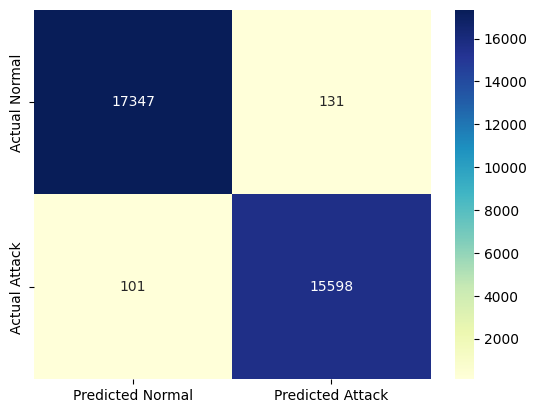

In [32]:
binary_model = RandomForestClassifier()
binary_model.fit(binary_train_X, binary_train_y)
binary_predictions = binary_model.predict(binary_val_X)

binary_prediction_data = add_predictions(df,
                                         binary_predictions,
                                         binary_val_y)

# create a heatmap of the confusion matrix
sns.heatmap(data=binary_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted Normal','Predicted Attack'],
            yticklabels = ['Actual Normal','Actual Attack'],
            cmap="YlGnBu",
            fmt='d',
            annot=True)
print("Random Forrest")

Logistic Regression


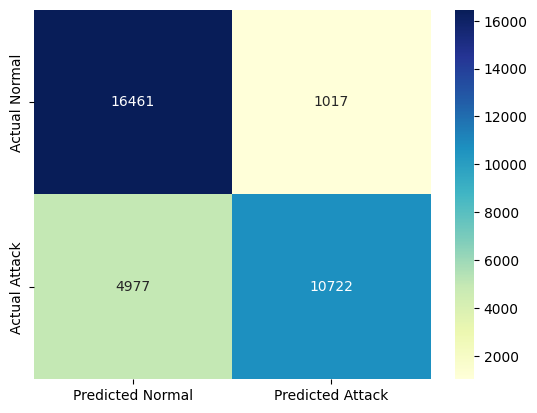

In [30]:
binary_model = LogisticRegression()
binary_model.fit(binary_train_X, binary_train_y)
binary_predictions = binary_model.predict(binary_val_X)

binary_prediction_data = add_predictions(df,
                                         binary_predictions,
                                         binary_val_y)

# create a heatmap of the confusion matrix
sns.heatmap(data=binary_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted Normal','Predicted Attack'],
            yticklabels = ['Actual Normal','Actual Attack'],
            cmap="YlGnBu",
            fmt='d',
            annot=True)
print("Logistic Regression")

K Neighbors Classifier


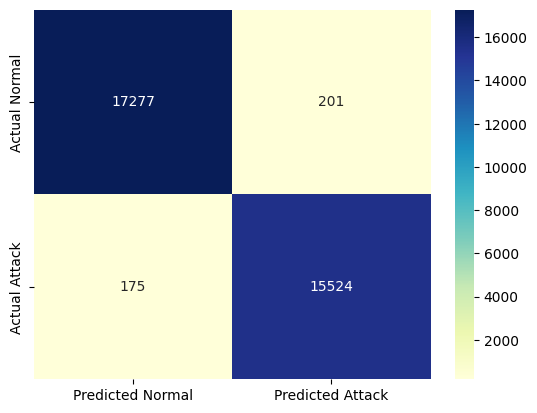

In [33]:
binary_model = KNeighborsClassifier()
binary_model.fit(binary_train_X, binary_train_y)
binary_predictions = binary_model.predict(binary_val_X)

binary_prediction_data = add_predictions(df,
                                         binary_predictions,
                                         binary_val_y)

# create a heatmap of the confusion matrix
sns.heatmap(data=binary_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted Normal','Predicted Attack'],
            yticklabels = ['Actual Normal','Actual Attack'],
            cmap="YlGnBu",
            fmt='d',
            annot=True)
print("K Neighbors Classifier")